Note book to compute
- The correlation between the `ja.factual_consistency` metric outputs and human annoted consistency scores converting `"contradiction" -> 0, "neutral" -> 0.5 and "entailment" -> 1`
- Ternary classification of the test data by `ja.factual_consistency` with 0.333.., 0.66... as the thresholds


In [2]:
# Load the benchmark datasets
import json

# These file can be downloaded from JGLUE/JNLI-v1.1
# https://github.com/yahoojapan/JGLUE/tree/main/datasets/jnli-v1.1

jnli_valid_path = 'data/valid-v1.1.json'


with open(jnli_valid_path) as f:
    file_lines = f.readlines()
    jnli_valid = [json.loads(line) for line in file_lines]

print(f'JNLI (valid) has {len(jnli_valid)} data points')


JNLI (valid) has 2434 data points


In [3]:
def _label_to_score(label):
    if label == 'contradiction':
        return 0.
    elif label == 'neutral':
        return 0.5
    elif label == 'entailment':
        return 1.
    else:
        raise ValueError(f'Invalid label: {label}')


jnli_valid_generated_outputs = [item['sentence2'] for item in jnli_valid]
jnli_valid_sources = [item['sentence1'] for item in jnli_valid]
jnli_valid_labels = [item ['label'] for item in jnli_valid]
jnli_valid_scores = [_label_to_score(label) for label in jnli_valid_labels]

In [4]:
from scipy.stats import spearmanr, pearsonr, kendalltau

def compute_correlation_values(metric_values, annotated_scores):
    '''Function to compute and output the correlation values between the metric
    score and the human annotation scores.'''
    # Ignore any data points where the evaluator returned `None`. This may happen
    # if, for example, the prompt triggers Azure OpenAI's content filter.
    nonnull_indices = [i for i in range(len(metric_values)) if metric_values[i] is not None]
    valid_metric_values = [metric_values[i] for i in nonnull_indices]
    valid_annotated_scores = [annotated_scores[i] for i in nonnull_indices]

    pearson_corr = pearsonr(valid_metric_values, valid_annotated_scores)[0]
    spearman_corr = spearmanr(valid_metric_values, valid_annotated_scores)[0]
    kendalltau_corr = kendalltau(valid_metric_values, valid_annotated_scores)[0]

    print(f'Pearson correlation = {pearson_corr}')
    print(f'Spearman correlation = {spearman_corr}')
    print(f'Kendall-Tau correlation = {kendalltau_corr}')

In [ ]:
# Compute the factual consistency scores on JNLI-v1.1 using the local
# (Translation + UniEval) model option and measure various correlations with the human annotated scores
from langcheck.metrics.ja import factual_consistency

result_scores = []
for i, (gen, src) in enumerate(zip(jnli_valid_generated_outputs, jnli_valid_sources)):
    result = factual_consistency(gen, src)
    result_scores.append(result.metric_values[0])

In [15]:
compute_correlation_values(result_scores, jnli_valid_scores)

# RUN-DATE: 2023-11-20
# Resulting correlation values:
#   Pearson correlation = 0.4915809916443343
#   Spearman correlation = 0.5095314982736171
#   Kendall-Tau correlation = 0.41396339413935745

Pearson correlation = 0.4915809916443343
Spearman correlation = 0.5095314982736171
Kendall-Tau correlation = 0.41396339413935745


In [ ]:
def _score_to_label(score, threshold1=1./3, threshold2=2./3):
    if score < threshold1:
        return 'contradiction'
    elif score < threshold2:
        return 'neutral'
    else:
        return 'entailment'

# Predict labels with the evenly distributed thresholds
predicted_labels_even = [_score_to_label(score) for score in result_scores]
accuracy = sum([pred == label for pred, label in zip(predicted_labels_even, jnli_valid_labels)]) / len(jnli_valid_labels)
print(f'Ternary classification accuracy = {accuracy}')
# RUN-DATE: 2023-11-20
#   Ternary classification accuracy = 0.49958915365653245

In [ ]:
!pip install seaborn

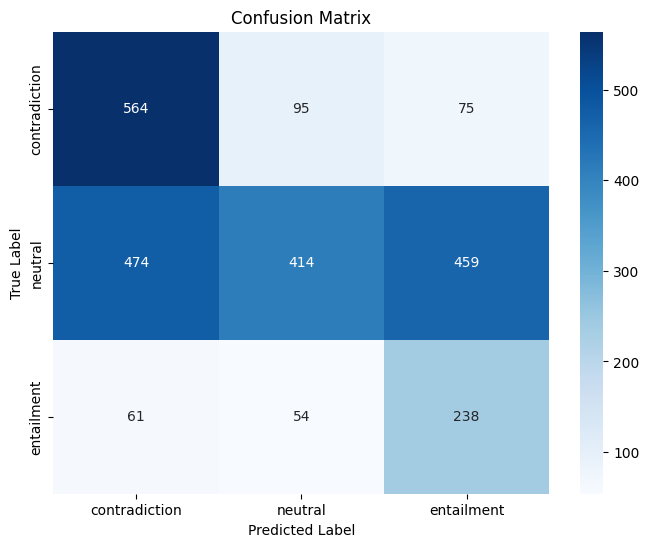

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['contradiction', 'neutral', 'entailment']

cm = confusion_matrix(jnli_valid_labels, predicted_labels_even, labels=labels)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Compute the factual consistency scores on JNLI-v1.1 using the OpenAI
# (gpt-3.5-turbo) model option and measure various correlations with the human
# annotated scores
from langcheck.metrics.ja import factual_consistency
import os

os.environ["AZURE_OPENAI_KEY"] = 'YOUR_AZURE_OPENAI_KEY'
os.environ["OPENAI_API_VERSION"] = 'YOUR_OPENAI_API_VERSION'
os.environ["AZURE_OPENAI_ENDPOINT"] = 'YOUR_AZURE_OPENAI_ENDPOINT'

result_scores = []
for i, (gen,
        src) in enumerate(zip(jnli_valid_generated_outputs,
                              jnli_valid_sources)):
    result = factual_consistency(gen,
                                 src,
                                 model_type='azure_openai',
                                 openai_args={'model': 'YOUR_DEPLOYMENT_NAME'})
    result_scores.append(result.metric_values[0])

In [7]:
compute_correlation_values(result_scores, jnli_valid_scores)

# RUN-DATE: 2023-11-20
# Azure OpenAI deployment details:
# - Model name: gpt-35-turbo
# - Model version: 0613
# - API version: 2023-07-01-preview
# Resulting correlation values:
#   (Computed on 2424 examples, since Azure's content filter rejected 10 prompts)
#   Pearson correlation = 0.5464182842415091
#   Spearman correlation = 0.5558043839096456
#   Kendall-Tau correlation = 0.5177757063494062

# RUN-DATE: 2023-12-05
# Azure OpenAI deployment details:
# - Model name: gpt-35-turbo
# - Model version: 0613
# - API version: 2023-07-01-preview
# Resulting correlation values:
#   (Computed on 2428 examples, since Azure's content filter rejected 6 prompts)
#   Pearson correlation = 0.5493314493430453
#   Spearman correlation = 0.5622045115401865
#   Kendall-Tau correlation = 0.5213717046528236

Pearson correlation = 0.5493314493430453
Spearman correlation = 0.5622045115401865
Kendall-Tau correlation = 0.5213717046528236


In [13]:
# Predict labels with the evenly distributed thresholds
def _score_to_label(score, threshold1=1./3, threshold2=2./3):
    if score is None:
        return 'undefined'
    if score < threshold1:
        return 'contradiction'
    elif score < threshold2:
        return 'neutral'
    else:
        return 'entailment'
predicted_labels_even = [_score_to_label(score) for score in result_scores]
accuracy = sum([pred == label for pred, label in zip(predicted_labels_even, jnli_valid_labels)]) / len(jnli_valid_labels)
print(f'Ternary classification accuracy = {accuracy}')
# RUN-DATE: 2023-11-20
# Azure OpenAI deployment details:
# - Model name: gpt-35-turbo
# - Model version: 0613
# - API version: 2023-07-01-preview
# Ternary classification accuracy = 0.6294165981922761

# RUN-DATE: 2023-12-05
# Azure OpenAI deployment details:
# - Model name: gpt-35-turbo
# - Model version: 0613
# - API version: 2023-07-01-preview
# Ternary classification accuracy = 0.6236647493837305

Ternary classification accuracy = 0.6236647493837305


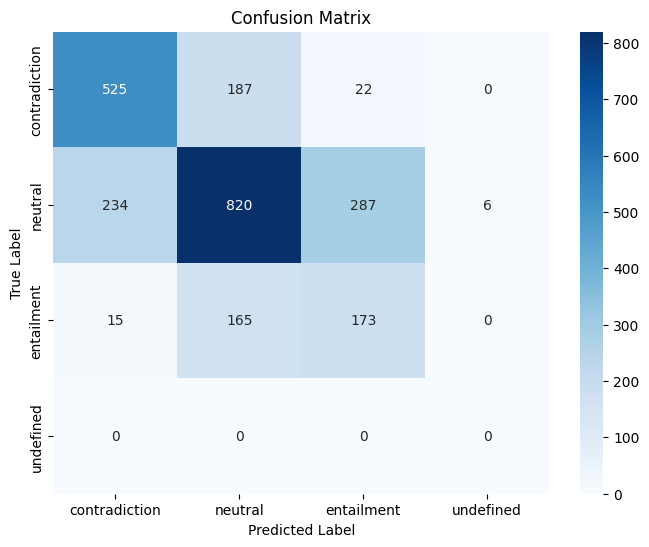

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['contradiction', 'neutral', 'entailment', 'undefined']
cm = confusion_matrix(jnli_valid_labels, predicted_labels_even, labels=labels)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()